# July 9th, 2021

**Motivation**: SVINET + fMRI + n = 100, p = {25, 15}, k = {4, 5} <br>


In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
svinet_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/svinet')


# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.network import Network
from analysis.helper import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE



def hierarchical_compare(
        hierarchical: dict,
        n_clusters: Union[range, list],
        key_fx: str = 'sub-SLC',
        keys_mv: List[str] = None,
        dist_measure: str = 'dice',
        cmap='RdYlBu_r',
        figsize=None, ):
    
    allen = hierarchical[key_fx].mice.allen
    contour = hierarchical[key_fx].mice.parcel.results2d['contour']
    
    keys_mv = keys_mv if keys_mv else ['ses-1', 'ses-2', 'ses-3']
    nrows, ncols = len(keys_mv) + 1, len(n_clusters)
    figsize = figsize if figsize else (13.5, 1.75 * nrows)
    fig, axes = create_figure(nrows, ncols, figsize=figsize)

    match_results = {}
    for j, n in tqdm(enumerate(n_clusters), total=len(n_clusters), leave=False):
        fx_masks = hierarchical[key_fx].results[n]['cluster_masks']
        _, x2d = masks2cluster(fx_masks, allen)
        
        cond = np.logical_or(contour, x2d == 0)
        _cond, _x = filter_boundaries([cond, x2d], mask=x2d.astype(bool))
        data2plt = np.ma.masked_where(_cond, _x)
        axes[0, j].imshow(data2plt, cmap=cmap)
        axes[0, j].set_title(f"n = {n}", fontsize=17, y=1.06)
        if j == 0:
            axes[0, j].set_ylabel(f"{key_fx}\n", fontsize=15)

        for i, key in enumerate(keys_mv):
            mv_masks = hierarchical[key].results[n]['cluster_masks']
            scores, mappings = clusters_sim_scores(fx_masks, mv_masks, weighted=True)
            match_results['_vs_'.join([key_fx, key])] = (scores, mappings)

            algn_idxs = list(mappings[dist_measure].values())
            mv_algn = dict(zip(
                list(mv_masks),
                np.array(list(mv_masks.values()))[algn_idxs]
            ))
            _, x2d_algn = masks2cluster(mv_algn, allen)

            cond = np.logical_or(contour, x2d_algn == 0)
            _cond, _x = filter_boundaries([cond, x2d_algn], mask=x2d_algn.astype(bool))
            data2plt = np.ma.masked_where(_cond, _x)
            axes[i + 1, j].imshow(data2plt, cmap=cmap)
            if j == 0:
                axes[i + 1, j].set_ylabel(f"{key}\n", fontsize=14)
    remove_ticks(axes)
    return fig, axes, match_results

### Report # voxels per ROI in the individual space
### Report estimated # neurons per ROI in individual space
### Add a checker that makes sure each ROI mask has at least one nonzero voxel

## SVINET

## k = 4

In [3]:
mice = Mice(Config(100))
mice.combine_dfs('rest')

key = 'sub-SLC'
metric = 'spearman'
mode = 'bold'
net = Network(
    mice=mice,
    key=key,
    metric=metric,
    mode=mode,
    binarize=False,
).fit()

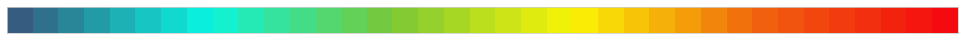

In [4]:
display_cmap(net.style['cmap'])

### Save Graphs

In [5]:
from analysis.network_helpers import save_edgelist, load_svinet

In [6]:
graphs = {}
for p in net.percentiles:
    graphs[f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_p-{p}"] = net.graphs[p]
    # graphs[f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_cfg_p-{p}"] = net.graphs_cfg[perc]

list(graphs)

[
    'bold_spearman_sub-SLC_n100_p-30',
    'bold_spearman_sub-SLC_n100_p-25',
    'bold_spearman_sub-SLC_n100_p-20',
    'bold_spearman_sub-SLC_n100_p-15',
    'bold_spearman_sub-SLC_n100_p-10'
]

In [8]:
for name, g in graphs.items():
    save_dir = pjoin(svinet_ws, name)
    os.makedirs(save_dir, exist_ok=True)
    save_edgelist(g, name=name, save_dir=save_dir)

### Load results

In [7]:
def get_filter_fn(num_comm, sampling=''):
    keywords = [f"k{num_comm}", sampling]
    def filter_fn(x):
        return all(k in x for k in keywords)
    return filter_fn

def _sort_fn(x):
    return next(
        int(e.replace('seed', '').strip())
        for e in x.split('-') if 'seed' in e
    )

In [8]:
perc = 25
expt_name = next(k for k in graphs if f"p-{perc}" in k)

num_comm = 4
sampling = 'linksampling'

In [9]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if name != expt_name:
        continue
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k4-mmsb-seed141-linksampling, # communities: 3

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k4-mmsb-seed323-linksampling, # communities: 3

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k4-mmsb-seed661-linksampling, # communities: 3

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k4-mmsb-seed681-linksampling, # communities: 3

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k4-mmsb-seed778-linksampling, # communities: 3

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k4-mmsb-seed859-linksampling, # communities: 3

In [10]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n100_p-25': 994}

In [11]:
run = list(svinet_results[expt_name].values())[51]

community = {
    i + 1: [net.n2l[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.n2l[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [12]:
run['num_overlap']

85

In [13]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.n2l), len(set(included_nodes)), num_overlap_nodes

(110, 110, 85)

In [14]:
[region for i, region in net.n2l.items() if i not in set(included_nodes)]

[]

In [15]:
npix_x, _, npix_z = mice.allen['template_info']['sizes']
dims_flat = (npix_x, npix_z)

contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

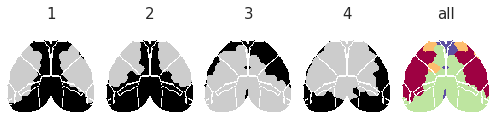

In [16]:
fig, axes = create_figure(1, num_comm + 1, (7, 2))

x2d_full = masks2partition(masks_isocortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap='Spectral')
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_isocortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    ax.imshow(data2plt, cmap='nipy_spectral')
    ax.set_title(i, fontsize=15)

remove_ticks(axes)
plt.show()

### Align using memship vectors

In [17]:
prototypes = []
for run in svinet_results[expt_name].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [18]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [19]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

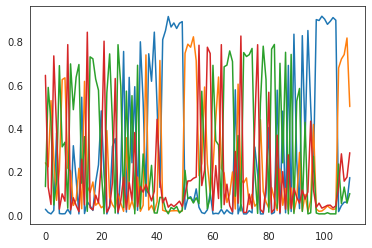

In [20]:
plt.plot(model.cluster_centers_.T);

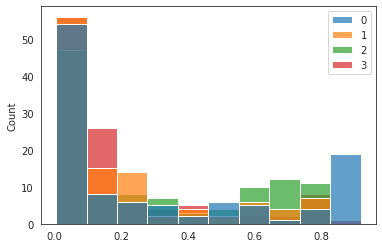

In [21]:
sns.histplot(model.cluster_centers_.T, alpha=0.7);

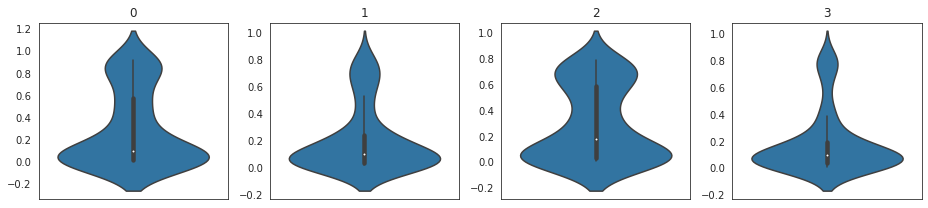

In [22]:
fig, axes = create_figure(1, num_comm, (13, 3))

for i in range(num_comm):
    sns.violinplot(y=model.cluster_centers_[i], ax=axes[i])
    axes[i].set_title(i)
plt.show()

In [23]:
memship_vec = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.n2l.items()
    } for i in range(num_comm)
}
memship_vol = vec2vol(memship_vec, mice)
memship_vol.keys()

dict_keys([1, 2, 3, 4])

In [24]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in tqdm(qs):
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f309379b4f0>

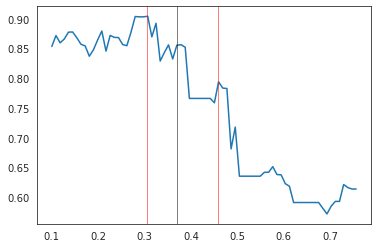

In [25]:
plt.plot(qs, sym_scores)
plt.axvline(0.305, color='r', lw=0.5)
plt.axvline(0.37, color='k', lw=0.5)
plt.axvline(0.459, color='r', lw=0.5)

In [26]:
q = 0.305
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}

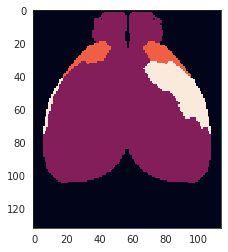

In [27]:
x3d, x2d = masks2partition(comms_quant, dims_flat)
plt.imshow(x2d);

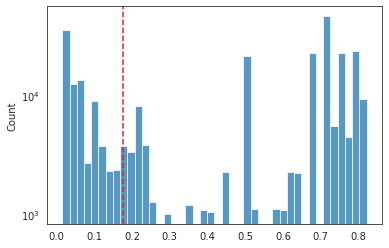

In [28]:
v = memship_vol[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')
plt.yscale('log')

In [29]:
q = 0.305 # 0.37  0.459

comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comms_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comms_vec_quant.values()))

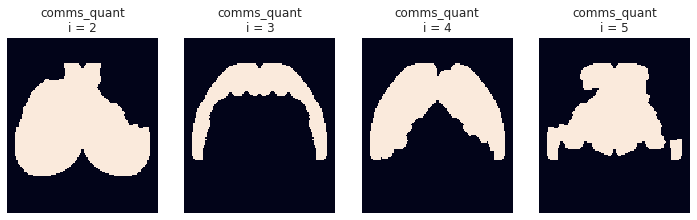

In [30]:
fig, axes = create_figure(1, num_comm, (10, 3.))

for ii in range(1, num_comm + 1):
    _, x2d = masks2partition(
        masks={ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])},
        dims_flat=dims_flat,
    )
    axes[ii - 1].imshow(x2d)
    axes[ii - 1].set_title(f"comms_quant\ni = {ii+1}")
    
remove_ticks(axes)

In [31]:
centers = dc(model.cluster_centers_)
metrics = [
    'cosine',
    'correlation',
    'braycurtis',
    'jensenshannon',
]
dict_list = []
perms = {}
for run_name, run in svinet_results[expt_name].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(float),
            XB=run['pi'].astype(float),
            metric=metric,
        ) for metric in metrics
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

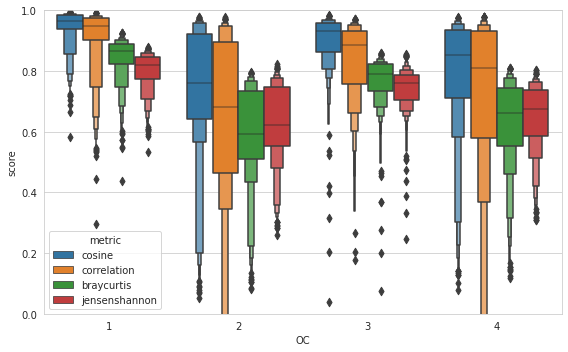

In [32]:
fig, ax = create_figure(1, 1, (8, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)
plt.show()

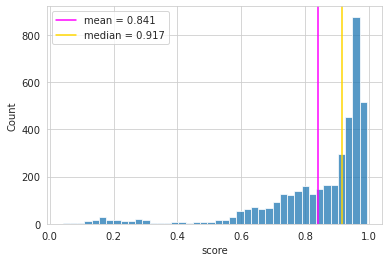

In [33]:
selected_df = results.loc[results.metric.isin(['cosine'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [34]:
svinet_aligned = collections.defaultdict(dict)
for name in svinet_results:
    for run_name, run in svinet_results[name].items():
        mapping = perms[run_name]
        mapping_inv = dict(map(reversed, mapping.items()))

        community = {
            mapping_inv[idx] + 1: [net.n2l[e] for e in comm_list]
            for idx, comm_list in run['community_sv'].items()
        }
        community = dict(sorted(community.items()))
        membership = {
            net.n2l[i]: mem[list(mapping.values())]
            for i, mem in run['membership_sv'].items()
        }
        partition = {
            net.n2l[i]: mapping_inv[idx] + 1
            for i, idx in run['partition_sv'].items()
        }
        pi = run['pi'][list(mapping.values())]
        
        _partition = {i: comm_idx for i, comm_idx in enumerate(np.argmax(pi, axis=0))}
        _pi = np.concatenate([np.reshape(item, (1, -1)) for item in membership.values()]).T
        if np.sum([i - 1 != j for i, j in zip(partition.values(), _partition.values())]) > 3:
            print('warning type 1')
        if np.abs(_pi - pi).sum() > 1e-10:
            print('warning type 2')
        
        run_aligned = {
            'community': community,
            'membership': membership,
            'partition': partition,
            'pi': np.round(pi, 2),
            'num_missing': run.get('num_missing'),
            'num_overlap': run.get('num_overlap'),            
        }
        svinet_aligned[name].update({run_name: run_aligned})
svinet_aligned = dict(svinet_aligned)

In [35]:
oc_aligned = {}
for run_name, run in svinet_aligned[expt_name].items():
    comm_vec = {
        idx: np.reshape([
            1 if region in v else 0
            for region in net.l2n
        ], (1, -1))
        for idx, v in run['community'].items()
    }
    oc_aligned[run_name] = np.concatenate(list(comm_vec.values()))

In [36]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [37]:
oc_flat_df.shape

(437360, 5)

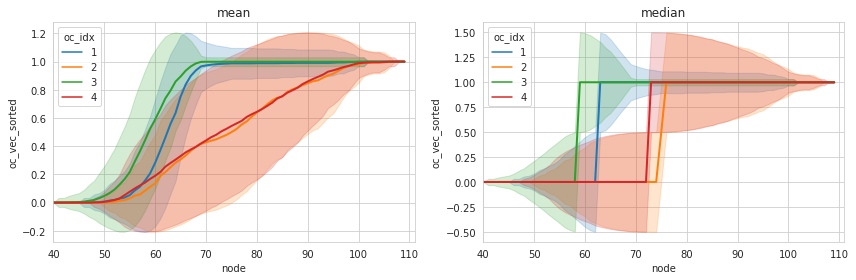

In [38]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [39]:
dict_list = []
for run_name, run in svinet_aligned[expt_name].items():
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'pi_vec': run['pi'][i],
            'pi_vec_sorted': sorted(run['pi'][i]),
        }
        dict_list.append(data_dict)
pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

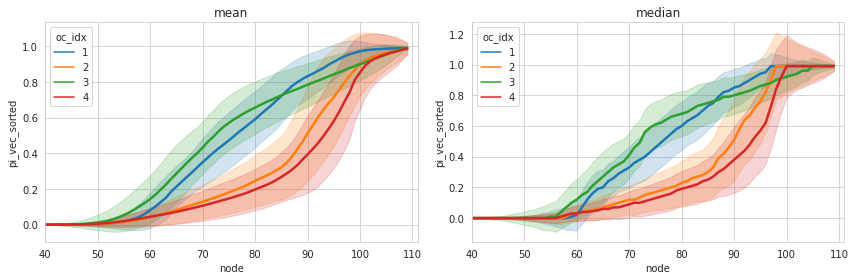

In [40]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=2.5,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [41]:
q = 0.305
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

In [42]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_aligned[expt_name].items()):
    if run_id > 10:
        break
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in community2masks(run['community'], mice).items()
    }
    masks_aligned[run_name] = masks_cortex

In [43]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2partition(comms_quant, dims_flat)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

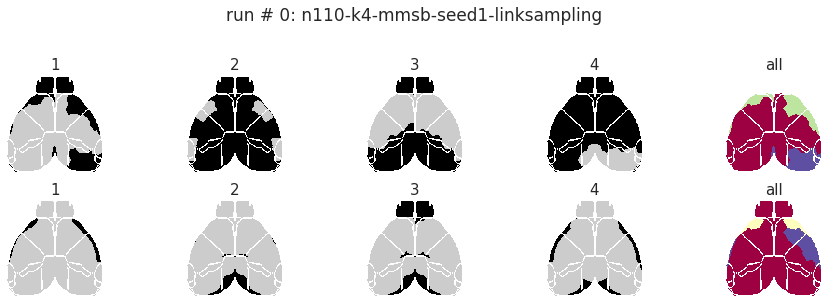

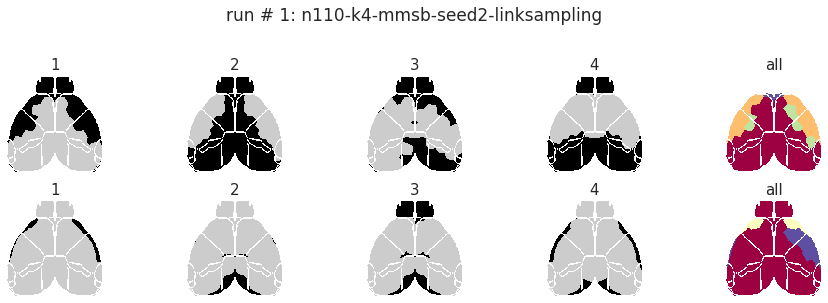

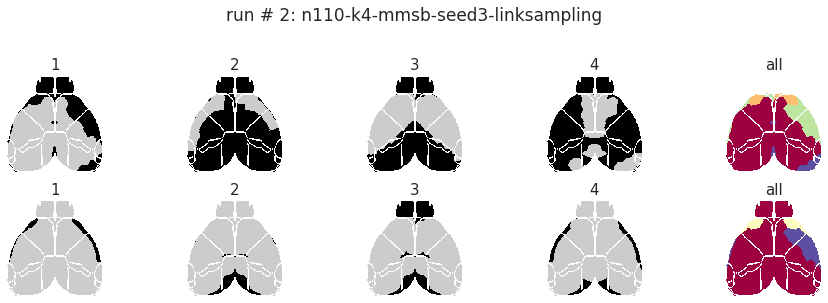

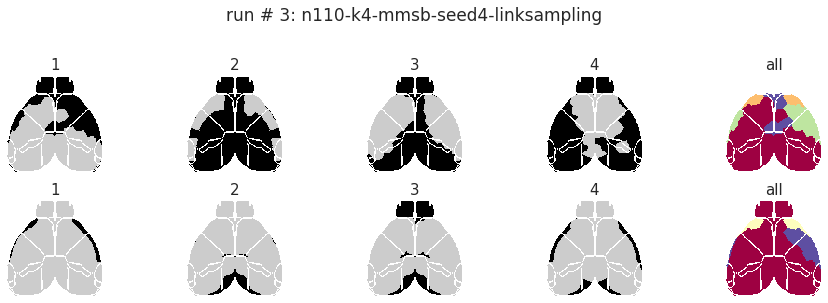

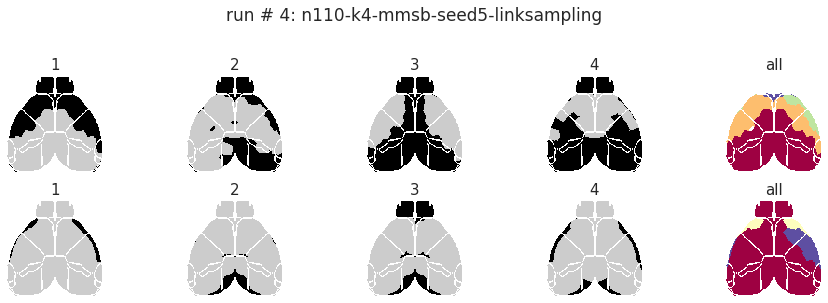

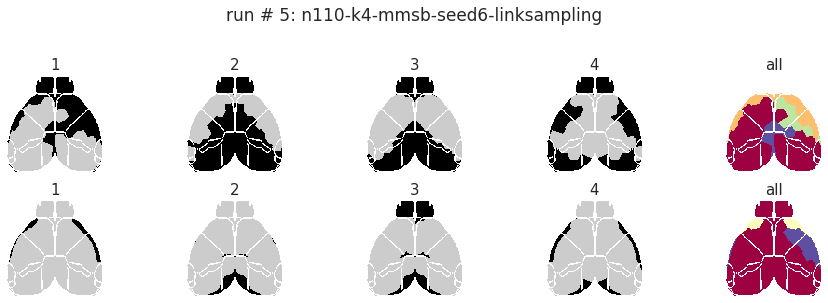

In [44]:
for run_id, (run_name, run) in enumerate(svinet_results[expt_name].items()):
    if run_id > 5:
        break
    
    fig, axes = create_figure(2, num_comm + 1, (13, 4))

    x2d_full = masks2partition(masks_aligned[run_name], dims_flat)[-1]
    x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
    cond = np.logical_or(contour, x2d_full == 0)
    data2plt = np.ma.masked_where(cond, x2d_full)
    axes[0, -1].imshow(data2plt, cmap='Spectral')
    axes[0, -1].set_title('all', fontsize=15)
    
    cond = np.logical_or(contour, x2d_full_can == 0)
    data2plt = np.ma.masked_where(cond, x2d_full_can)
    axes[1, -1].imshow(data2plt, cmap='Spectral')
    axes[1, -1].set_title('all', fontsize=15)

    for i, ax0, ax1 in zip(range(1, num_comm+1), axes[0], axes[1]):
        x2d = masks2partition({i: masks_aligned[run_name][i]}, dims_flat)[-1]
        x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d)
        ax0.imshow(data2plt, cmap='nipy_spectral')
        ax0.set_title(i, fontsize=15)
        
        x2d_can = masks2partition({i: comms_quant[i]}, dims_flat)[-1]
        x2d_can = filter_boundaries(x2d_can, mice.parcel.results2d['atlas'])
        data2plt = np.ma.masked_where(cond, x2d_can)
        ax1.imshow(data2plt, cmap='nipy_spectral')
        ax1.set_title(i, fontsize=15)

    remove_ticks(axes)
    fig.suptitle(f"run # {run_id}: {run_name}", fontsize=17, y=1.04)
    plt.show()
    
    print('\n\n')

In [45]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [46]:
dict_list = []
for run_name, run in tqdm(svinet_aligned[expt_name].items()):
    for i in range(num_comm):
        mem = run['pi'][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()       
        
        counts = mem_cut.values.tolist()
        if not sum(counts):
            print('vay dada: ', run_name, i)
            continue
        
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/994 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [47]:
pi_cut_df.shape

(39760, 5)

In [48]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

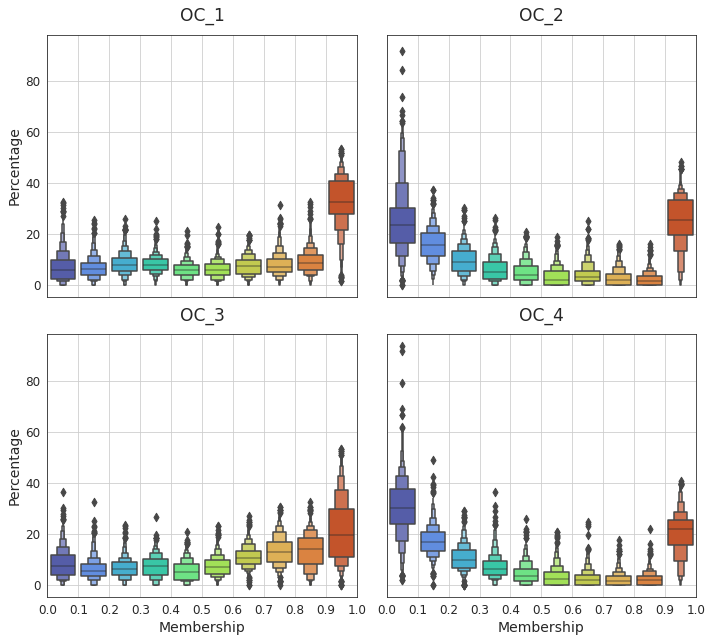

In [49]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (10, 9), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=12)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

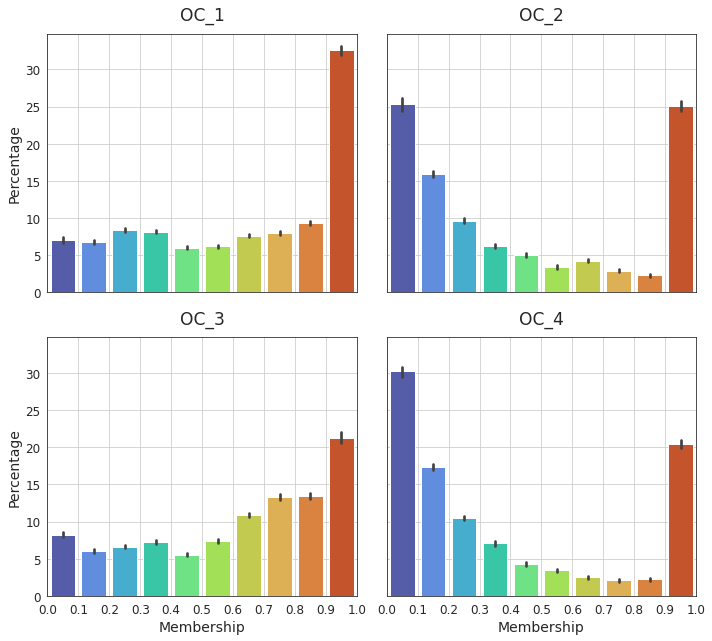

In [50]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (10, 9), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )

    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=12)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [51]:
q = 0.305
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [52]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#edf53d',
    '#f53d91', '#3df5f1', '#f5603d',
    '#92f53d', '#3d46f5', '#f53def',
    '#f5a37a', 
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

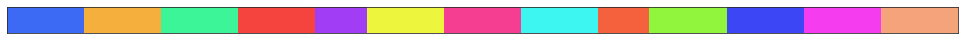

In [53]:
oc_cmap = make_cmap(
    list(colors_fancy.values()),
    n_colors=len(colors_fancy),
    name='OC',
)

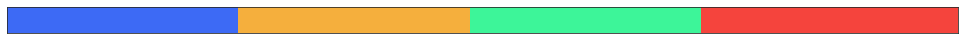

In [54]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

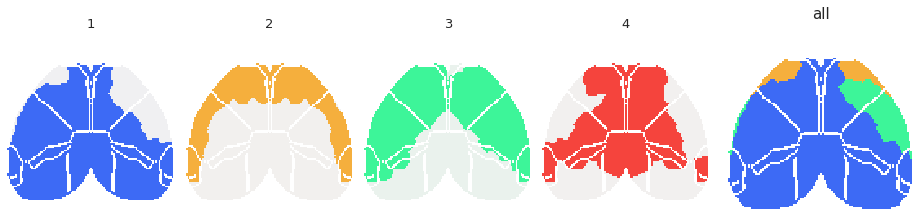

In [55]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [56]:
import ants
template = ants.from_numpy(mice.allen['template'].astype(float))

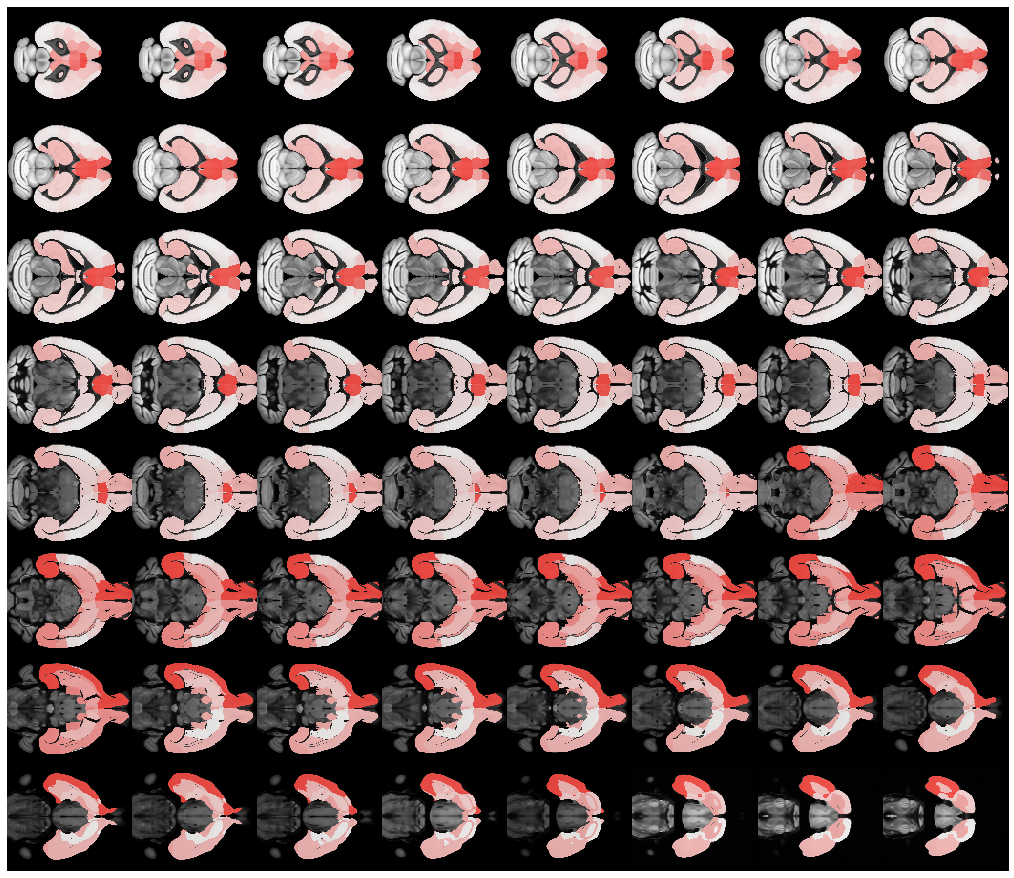

In [57]:
i = 4
img = ants.from_numpy(memship_vol[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [58]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_overlap",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p25_overlap_k4.html

### Disjoint

In [59]:
partition = np.argmax(model.cluster_centers_, axis=0)
partition = {
    net.n2l[i]: idx + 1
    for i, idx in enumerate(partition)
}
community = {
    ii: list(itertools.compress(
        data=net.l2n,
        selectors=[ii == jj for jj in partition.values()],
    ))
    for ii in set(partition.values())
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in community2masks(community, mice).items()
}

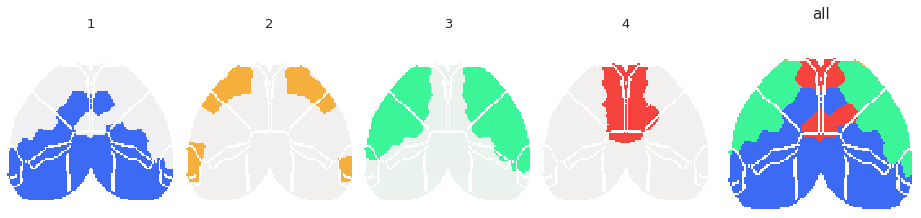

In [60]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [61]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_disjoint",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p25_disjoint_k4.html

## Sparse (perc=15)

In [62]:
perc = 15
expt_name = next(k for k in graphs if f"p-{perc}" in k)

num_comm = 4
sampling = 'linksampling'

In [63]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if name != expt_name:
        continue
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n100_p-15': 1000}

In [65]:
run = list(svinet_results[expt_name].values())[51]

community = {
    i + 1: [net.n2l[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.n2l[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [66]:
run['num_overlap']

46

In [67]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.n2l), len(set(included_nodes)), num_overlap_nodes

(110, 109, 46)

In [68]:
[region for i, region in net.n2l.items() if i not in set(included_nodes)]

['0-315-41']

In [69]:
npix_x, _, npix_z = mice.allen['template_info']['sizes']
dims_flat = (npix_x, npix_z)

contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

### Align using memship vectors

In [71]:
prototypes = []
for run in svinet_results[expt_name].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [72]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [73]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

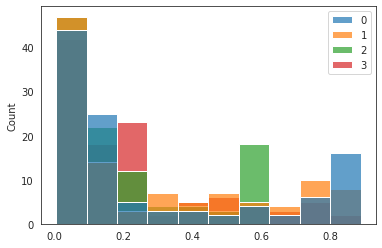

In [75]:
sns.histplot(model.cluster_centers_.T, alpha=0.7);

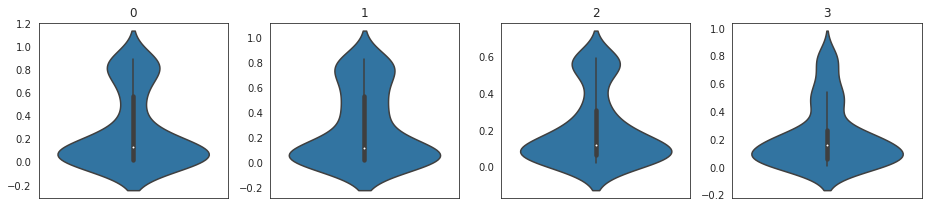

In [76]:
fig, axes = create_figure(1, num_comm, (13, 3))

for i in range(num_comm):
    sns.violinplot(y=model.cluster_centers_[i], ax=axes[i])
    axes[i].set_title(i)
plt.show()

In [77]:
memship_vec = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.n2l.items()
    } for i in range(num_comm)
}
memship_vol = vec2vol(memship_vec, mice)

In [78]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in tqdm(qs):
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

<matplotlib.lines.Line2D object at 0x7f2feccf2730>

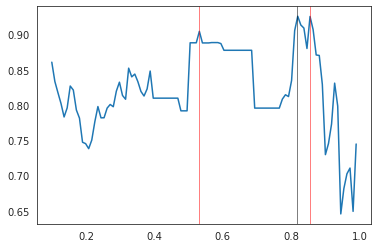

In [79]:
plt.plot(qs, sym_scores)
plt.axvline(0.53, color='r', lw=0.5)
plt.axvline(0.817, color='k', lw=0.5)
plt.axvline(0.854, color='r', lw=0.5)

In [80]:
q_good = [0.53, 0.817, 0.854]

In [81]:
q = q_good[0]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}

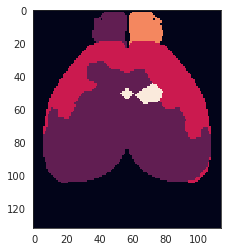

In [82]:
x3d, x2d = masks2partition(comms_quant, dims_flat)
plt.imshow(x2d);

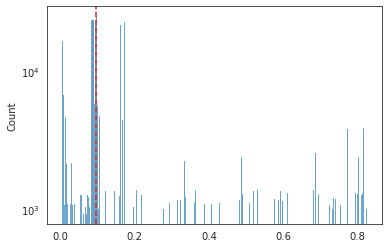

In [83]:
v = memship_vol[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')
plt.yscale('log')

In [84]:
q = q_good[0]

comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comms_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comms_vec_quant.values()))

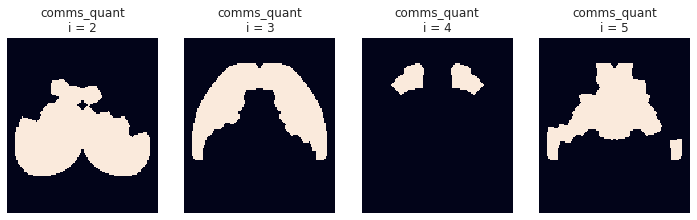

In [85]:
fig, axes = create_figure(1, num_comm, (10, 3.))

for ii in range(1, num_comm + 1):
    _, x2d = masks2partition(
        masks={ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])},
        dims_flat=dims_flat,
    )
    axes[ii - 1].imshow(x2d)
    axes[ii - 1].set_title(f"comms_quant\ni = {ii+1}")
    
remove_ticks(axes)

In [86]:
centers = dc(model.cluster_centers_)
metrics = [
    'cosine',
    'correlation',
    'braycurtis',
    'jensenshannon',
]
dict_list = []
perms = {}
for run_name, run in svinet_results[expt_name].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(float),
            XB=run['pi'].astype(float),
            metric=metric,
        ) for metric in metrics
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

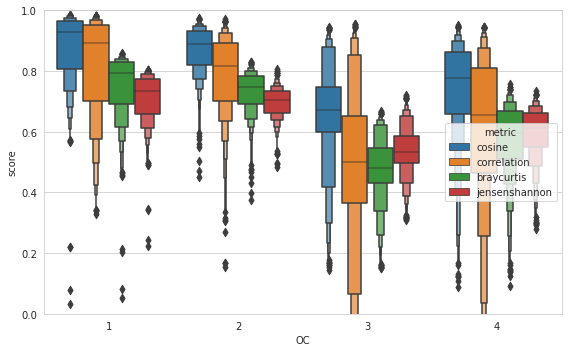

In [87]:
fig, ax = create_figure(1, 1, (8, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)
plt.show()

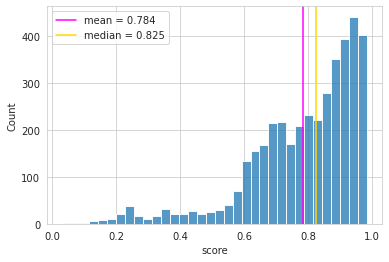

In [88]:
selected_df = results.loc[results.metric.isin(['cosine'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [89]:
svinet_aligned = collections.defaultdict(dict)
for name in svinet_results:
    for run_name, run in svinet_results[name].items():
        mapping = perms[run_name]
        mapping_inv = dict(map(reversed, mapping.items()))

        community = {
            mapping_inv[idx] + 1: [net.n2l[e] for e in comm_list]
            for idx, comm_list in run['community_sv'].items()
        }
        community = dict(sorted(community.items()))
        membership = {
            net.n2l[i]: mem[list(mapping.values())]
            for i, mem in run['membership_sv'].items()
        }
        partition = {
            net.n2l[i]: mapping_inv[idx] + 1
            for i, idx in run['partition_sv'].items()
        }
        pi = run['pi'][list(mapping.values())]
        
        _partition = {i: comm_idx for i, comm_idx in enumerate(np.argmax(pi, axis=0))}
        _pi = np.concatenate([np.reshape(item, (1, -1)) for item in membership.values()]).T
        if np.sum([i - 1 != j for i, j in zip(partition.values(), _partition.values())]) > 3:
            print('warning type 1')
        if np.abs(_pi - pi).sum() > 1e-10:
            print('warning type 2')
        
        run_aligned = {
            'community': community,
            'membership': membership,
            'partition': partition,
            'pi': np.round(pi, 2),
            'num_missing': run.get('num_missing'),
            'num_overlap': run.get('num_overlap'),            
        }
        svinet_aligned[name].update({run_name: run_aligned})
svinet_aligned = dict(svinet_aligned)

In [90]:
oc_aligned = {}
for run_name, run in svinet_aligned[expt_name].items():
    comm_vec = {
        idx: np.reshape([
            1 if region in v else 0
            for region in net.l2n
        ], (1, -1))
        for idx, v in run['community'].items()
    }
    oc_aligned[run_name] = np.concatenate(list(comm_vec.values()))

In [91]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [92]:
oc_flat_df.shape

(440000, 5)

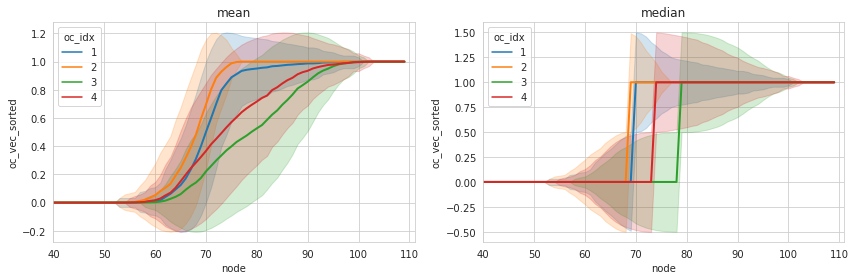

In [93]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [94]:
dict_list = []
for run_name, run in svinet_aligned[expt_name].items():
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'pi_vec': run['pi'][i],
            'pi_vec_sorted': sorted(run['pi'][i]),
        }
        dict_list.append(data_dict)
pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

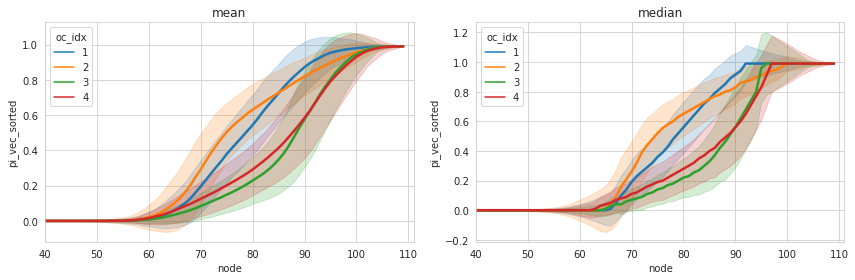

In [95]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=2.5,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [96]:
q = q_good[0]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

In [97]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_aligned[expt_name].items()):
    if run_id > 10:
        break
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in community2masks(run['community'], mice).items()
    }
    masks_aligned[run_name] = masks_cortex

In [98]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2partition(comms_quant, dims_flat)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

In [100]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [101]:
dict_list = []
for run_name, run in tqdm(svinet_aligned[expt_name].items()):
    for i in range(num_comm):
        mem = run['pi'][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()       
        
        counts = mem_cut.values.tolist()
        if not sum(counts):
            print('vay dada: ', run_name, i)
            continue
        
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/1000 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [102]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

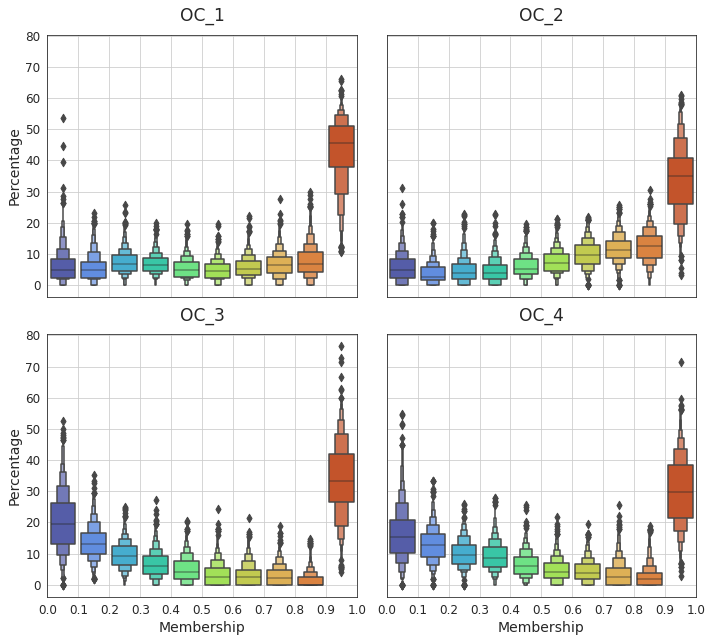

In [103]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (10, 9), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=12)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

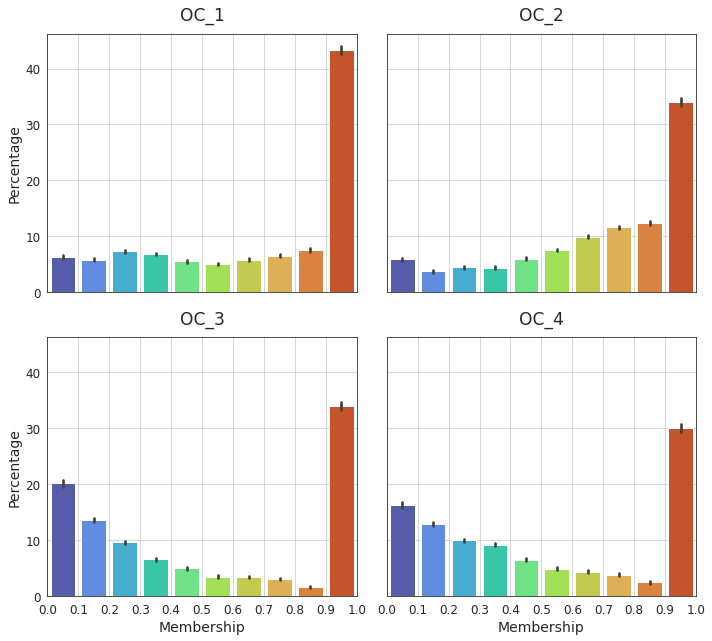

In [104]:
nrows = 2
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (10, 9), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )

    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=12)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=17, y=1.03)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=14)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=14)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [105]:
q = q_good[0]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [106]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#edf53d',
    '#f53d91', '#3df5f1', '#f5603d',
    '#92f53d', '#3d46f5', '#f53def',
    '#f5a37a', 
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

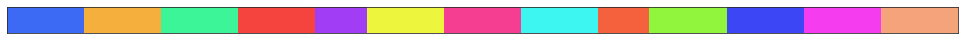

In [107]:
oc_cmap = make_cmap(
    list(colors_fancy.values()),
    n_colors=len(colors_fancy),
    name='OC',
)

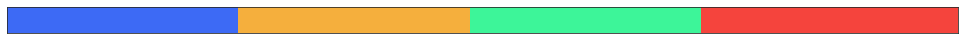

In [108]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

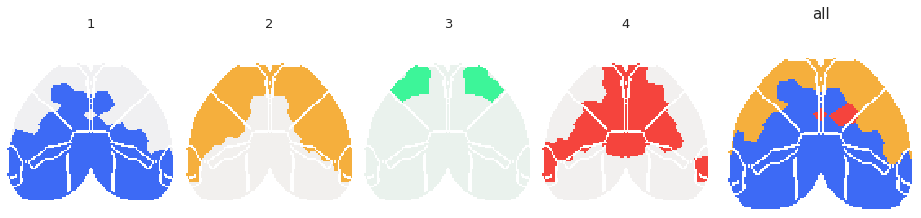

In [109]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [110]:
import ants
template = ants.from_numpy(mice.allen['template'].astype(float))

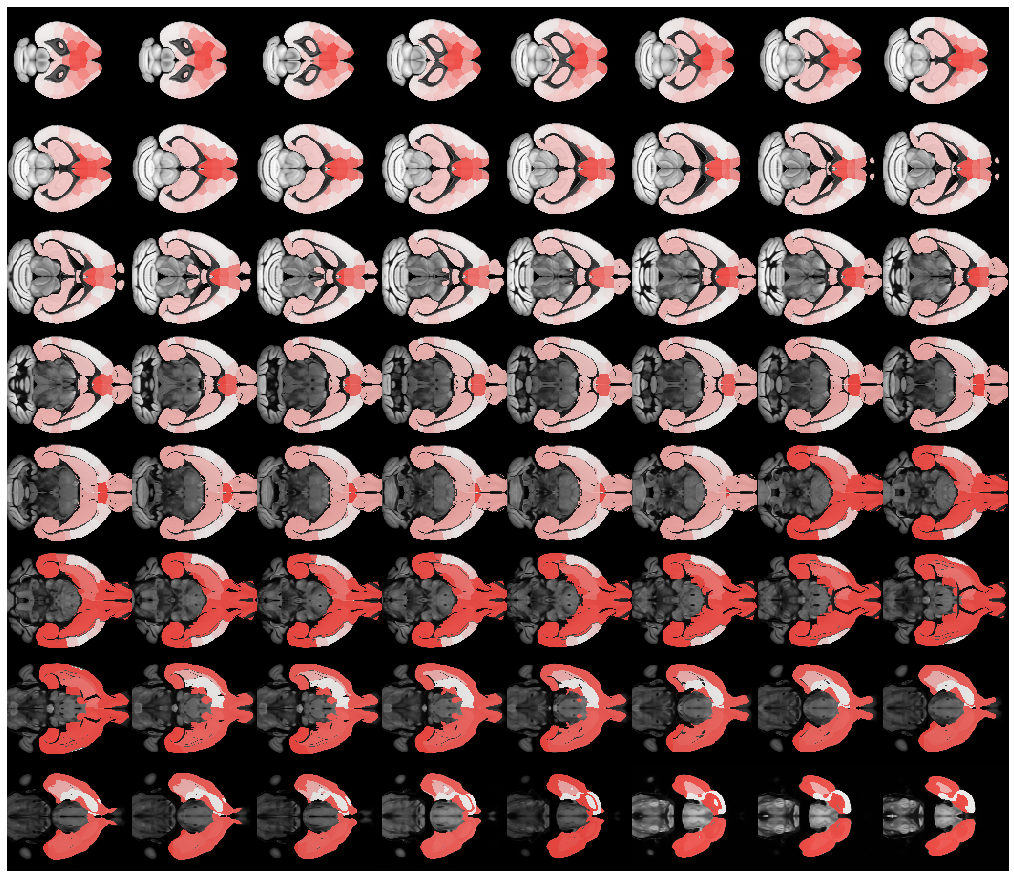

In [111]:
i = 4
img = ants.from_numpy(memship_vol[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [112]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_overlap",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p15_overlap_k4.html

### Crisp

In [113]:
partition = np.argmax(model.cluster_centers_, axis=0)
partition = {
    net.n2l[i]: idx + 1
    for i, idx in enumerate(partition)
}
community = {
    ii: list(itertools.compress(
        data=net.l2n,
        selectors=[ii == jj for jj in partition.values()],
    ))
    for ii in set(partition.values())
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in community2masks(community, mice).items()
}

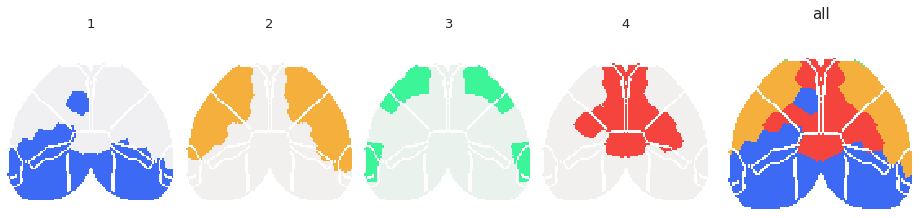

In [114]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [115]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_disjoint",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p15_disjoint_k4.html

## k = 5

In [138]:
mice = Mice(Config(100))
mice.combine_dfs('rest')

key = 'sub-SLC'
metric = 'spearman'
mode = 'bold'
net = Network(
    mice=mice,
    key=key,
    metric=metric,
    mode=mode,
    binarize=False,
).fit()

In [139]:
from analysis.network_helpers import save_edgelist, load_svinet

In [140]:
graphs = {}
for p in net.percentiles:
    graphs[f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_p-{p}"] = net.graphs[p]
    # graphs[f"{mode}_{metric}_{key}_n{mice.parcel.results['n_cortical_regions']}_cfg_p-{p}"] = net.graphs_cfg[perc]

list(graphs)

[
    'bold_spearman_sub-SLC_n100_p-30',
    'bold_spearman_sub-SLC_n100_p-25',
    'bold_spearman_sub-SLC_n100_p-20',
    'bold_spearman_sub-SLC_n100_p-15',
    'bold_spearman_sub-SLC_n100_p-10'
]

### Load results

In [141]:
def get_filter_fn(num_comm, sampling=''):
    keywords = [f"k{num_comm}", sampling]
    def filter_fn(x):
        return all(k in x for k in keywords)
    return filter_fn

def _sort_fn(x):
    return next(
        int(e.replace('seed', '').strip())
        for e in x.split('-') if 'seed' in e
    )

In [142]:
perc = 25
expt_name = next(k for k in graphs if f"p-{perc}" in k)

num_comm = 5
sampling = 'linksampling'

In [143]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if name != expt_name:
        continue
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed211-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed330-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed463-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed476-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed627-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed643-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed651-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed675-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed735-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed781-linksampling, # communities: 3

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed961-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-25
bad fit: n110-k5-mmsb-seed983-linksampling, # communities: 4

In [144]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n100_p-25': 988}

In [145]:
run = list(svinet_results[expt_name].values())[51]

community = {
    i + 1: [net.n2l[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.n2l[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [146]:
run['num_overlap']

102

In [147]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.n2l), len(set(included_nodes)), num_overlap_nodes

(110, 110, 102)

In [148]:
[region for i, region in net.n2l.items() if i not in set(included_nodes)]

[]

In [149]:
npix_x, _, npix_z = mice.allen['template_info']['sizes']
dims_flat = (npix_x, npix_z)

contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

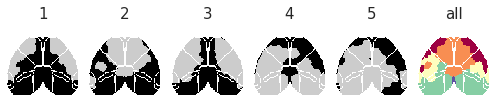

In [150]:
fig, axes = create_figure(1, num_comm + 1, (7, 2))

x2d_full = masks2partition(masks_isocortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
axes[-1].imshow(data2plt, cmap='Spectral')
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_isocortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    ax.imshow(data2plt, cmap='nipy_spectral')
    ax.set_title(i, fontsize=15)

remove_ticks(axes)
plt.show()

### Align using memship vectors

In [151]:
prototypes = []
for run in svinet_results[expt_name].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [152]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [153]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

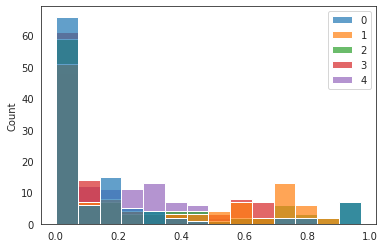

In [154]:
sns.histplot(model.cluster_centers_.T, alpha=0.7);

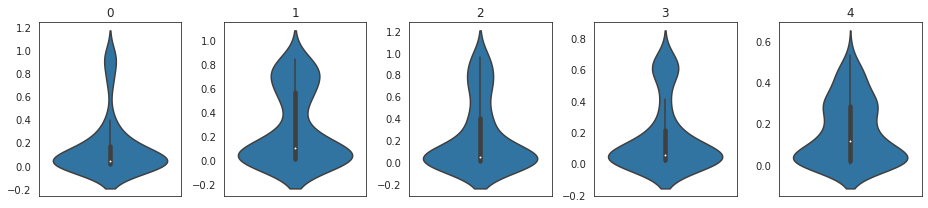

In [155]:
fig, axes = create_figure(1, num_comm, (13, 3))

for i in range(num_comm):
    sns.violinplot(y=model.cluster_centers_[i], ax=axes[i])
    axes[i].set_title(i)
plt.show()

In [156]:
memship_vec = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.n2l.items()
    } for i in range(num_comm)
}
memship_vol = vec2vol(memship_vec, mice)
memship_vol.keys()

dict_keys([1, 2, 3, 4, 5])

In [157]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in tqdm(qs):
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

/home/hadi/Dropbox/git/Ca-fMRI/analysis/helper.py:181: RuntimeWarning:

invalid value encountered in long_scalars



<matplotlib.lines.Line2D object at 0x7f2fb4195340>

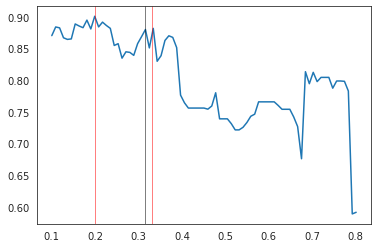

In [176]:
plt.plot(qs, sym_scores)
plt.axvline(0.2, color='r', lw=0.5)
plt.axvline(0.314, color='k', lw=0.5)
plt.axvline(0.332, color='r', lw=0.5)

In [177]:
q_good = [0.2, 0.314, 0.332]

In [178]:
q = q_good[0]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}

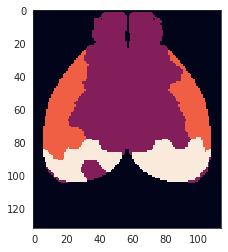

In [179]:
x3d, x2d = masks2partition(comms_quant, dims_flat)
plt.imshow(x2d);

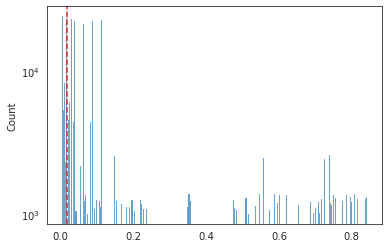

In [180]:
v = memship_vol[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')
plt.yscale('log')

In [181]:
q = q_good[0]

comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comms_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comms_vec_quant.values()))

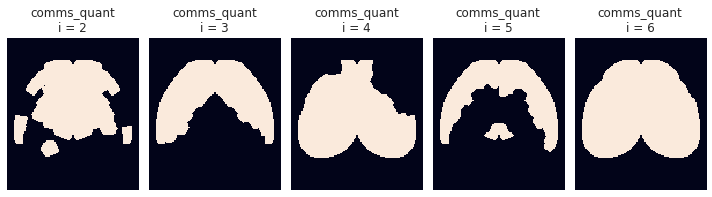

In [182]:
fig, axes = create_figure(1, num_comm, (10, 3.))

for ii in range(1, num_comm + 1):
    _, x2d = masks2partition(
        masks={ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])},
        dims_flat=dims_flat,
    )
    axes[ii - 1].imshow(x2d)
    axes[ii - 1].set_title(f"comms_quant\ni = {ii+1}")
    
remove_ticks(axes)

In [183]:
centers = dc(model.cluster_centers_)
metrics = [
    'cosine',
    'correlation',
    'braycurtis',
    'jensenshannon',
]
dict_list = []
perms = {}
for run_name, run in svinet_results[expt_name].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(float),
            XB=run['pi'].astype(float),
            metric=metric,
        ) for metric in metrics
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

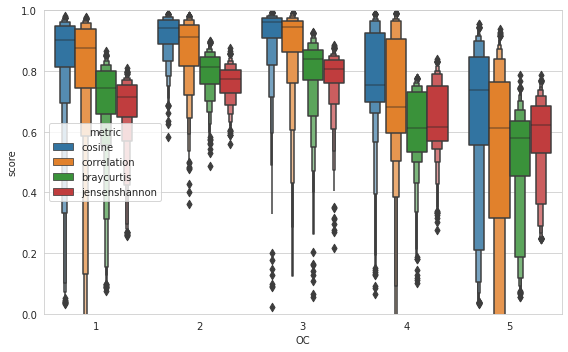

In [184]:
fig, ax = create_figure(1, 1, (8, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)
plt.show()

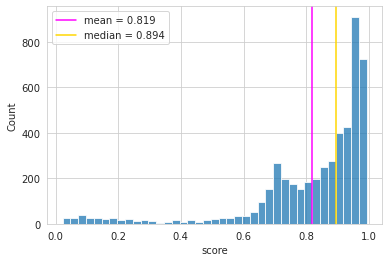

In [185]:
selected_df = results.loc[results.metric.isin(['cosine'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [186]:
svinet_aligned = collections.defaultdict(dict)
for name in svinet_results:
    for run_name, run in svinet_results[name].items():
        mapping = perms[run_name]
        mapping_inv = dict(map(reversed, mapping.items()))

        community = {
            mapping_inv[idx] + 1: [net.n2l[e] for e in comm_list]
            for idx, comm_list in run['community_sv'].items()
        }
        community = dict(sorted(community.items()))
        membership = {
            net.n2l[i]: mem[list(mapping.values())]
            for i, mem in run['membership_sv'].items()
        }
        partition = {
            net.n2l[i]: mapping_inv[idx] + 1
            for i, idx in run['partition_sv'].items()
        }
        pi = run['pi'][list(mapping.values())]
        
        _partition = {i: comm_idx for i, comm_idx in enumerate(np.argmax(pi, axis=0))}
        _pi = np.concatenate([np.reshape(item, (1, -1)) for item in membership.values()]).T
        if np.sum([i - 1 != j for i, j in zip(partition.values(), _partition.values())]) > 3:
            print('warning type 1')
        if np.abs(_pi - pi).sum() > 1e-10:
            print('warning type 2')
        
        run_aligned = {
            'community': community,
            'membership': membership,
            'partition': partition,
            'pi': np.round(pi, 2),
            'num_missing': run.get('num_missing'),
            'num_overlap': run.get('num_overlap'),            
        }
        svinet_aligned[name].update({run_name: run_aligned})
svinet_aligned = dict(svinet_aligned)

In [187]:
oc_aligned = {}
for run_name, run in svinet_aligned[expt_name].items():
    comm_vec = {
        idx: np.reshape([
            1 if region in v else 0
            for region in net.l2n
        ], (1, -1))
        for idx, v in run['community'].items()
    }
    oc_aligned[run_name] = np.concatenate(list(comm_vec.values()))

In [188]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [189]:
oc_flat_df.shape

(543400, 5)

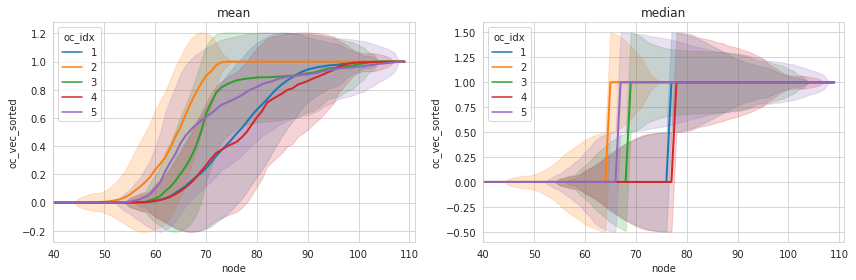

In [190]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [191]:
dict_list = []
for run_name, run in svinet_aligned[expt_name].items():
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'pi_vec': run['pi'][i],
            'pi_vec_sorted': sorted(run['pi'][i]),
        }
        dict_list.append(data_dict)
pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

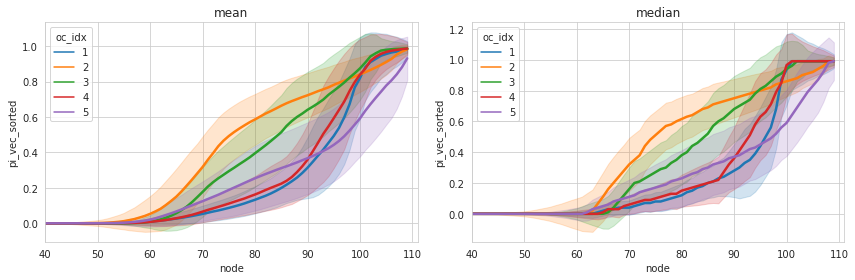

In [192]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=2.5,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [194]:
q = q_good[0]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

In [195]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_aligned[expt_name].items()):
    if run_id > 10:
        break
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in community2masks(run['community'], mice).items()
    }
    masks_aligned[run_name] = masks_cortex

In [196]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2partition(comms_quant, dims_flat)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

In [197]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [198]:
dict_list = []
for run_name, run in tqdm(svinet_aligned[expt_name].items()):
    for i in range(num_comm):
        mem = run['pi'][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()       
        
        counts = mem_cut.values.tolist()
        if not sum(counts):
            print('vay dada: ', run_name, i)
            continue
        
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/988 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [47]:
pi_cut_df.shape

(39760, 5)

In [199]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

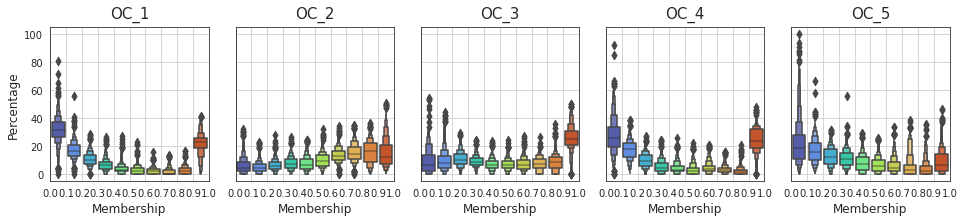

In [209]:
nrows = 1
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 3.2), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=10)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=15, y=1.02)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=12)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

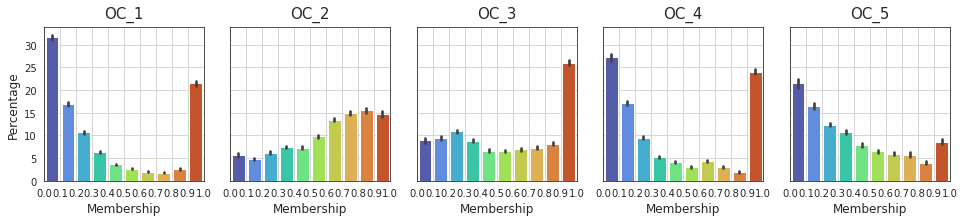

In [211]:
nrows = 1
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 3.2), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )

    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=10)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=15, y=1.02)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=12)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [218]:
q = q_good[1]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [219]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#edf53d',
    '#f53d91', '#3df5f1', '#f5603d',
    '#92f53d', '#3d46f5', '#f53def',
    '#f5a37a', 
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

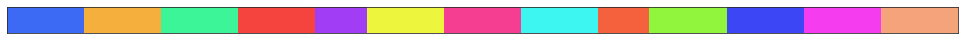

In [220]:
oc_cmap = make_cmap(
    list(colors_fancy.values()),
    n_colors=len(colors_fancy),
    name='OC',
)

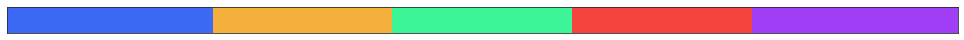

In [221]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

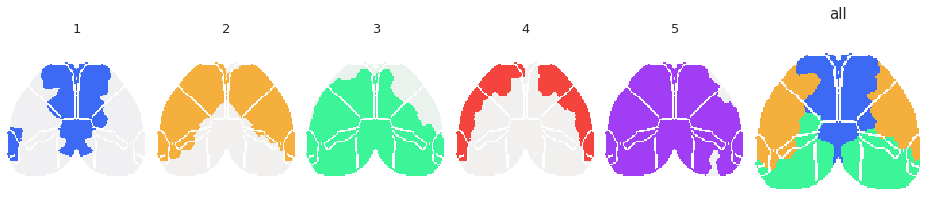

In [222]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [223]:
import ants
template = ants.from_numpy(mice.allen['template'].astype(float))

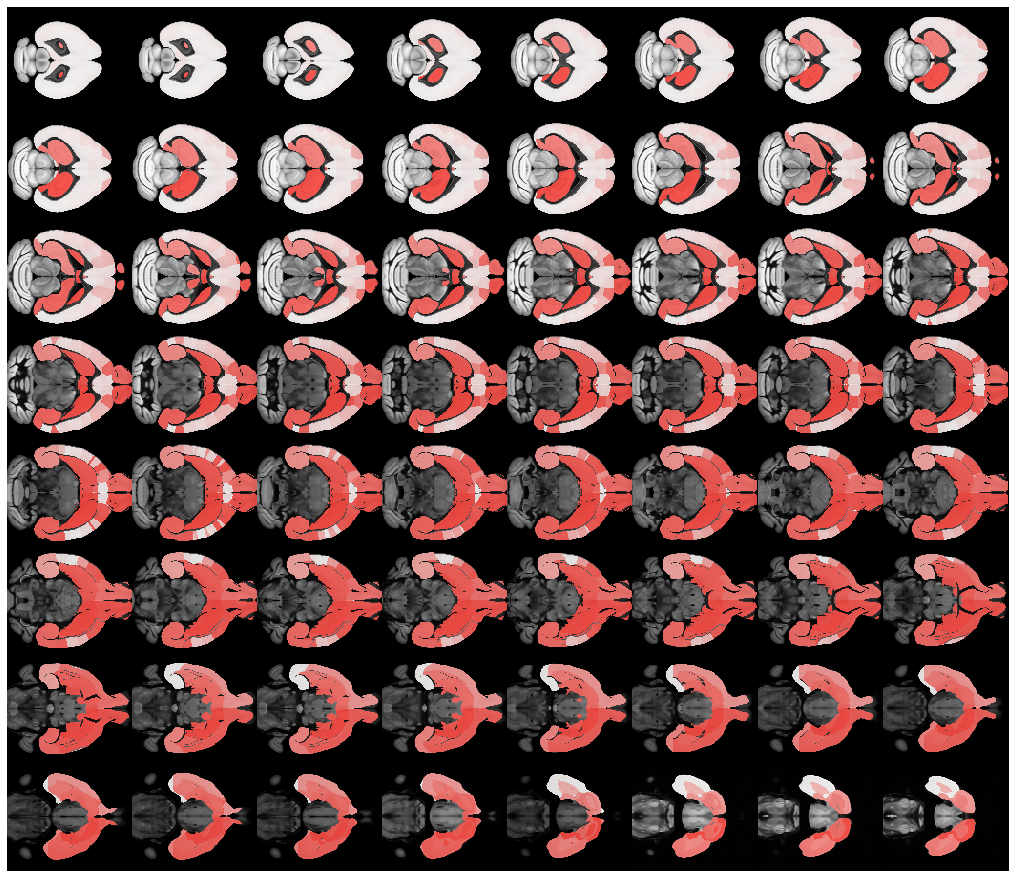

In [224]:
i = 4
img = ants.from_numpy(memship_vol[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [225]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_overlap",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p25_overlap_k5.html

### Disjoint

In [226]:
partition = np.argmax(model.cluster_centers_, axis=0)
partition = {
    net.n2l[i]: idx + 1
    for i, idx in enumerate(partition)
}
community = {
    ii: list(itertools.compress(
        data=net.l2n,
        selectors=[ii == jj for jj in partition.values()],
    ))
    for ii in set(partition.values())
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in community2masks(community, mice).items()
}

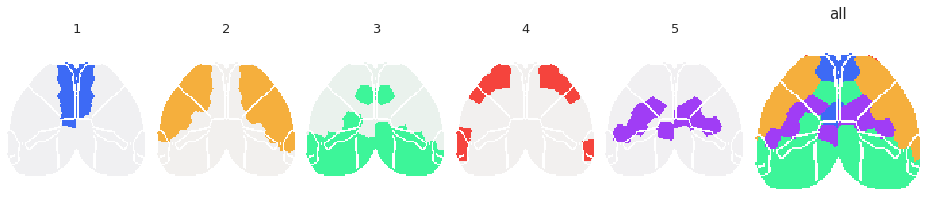

In [227]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [228]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_disjoint",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p25_disjoint_k5.html

## Sparse (perc=15)

In [229]:
perc = 15
expt_name = next(k for k in graphs if f"p-{perc}" in k)

num_comm = 5
sampling = 'linksampling'

In [230]:
svinet_results = collections.defaultdict(dict)
for name in graphs:
    if name != expt_name:
        continue
    load_dir = pjoin(svinet_ws, name)
    results_list = next(os.walk(load_dir))[1]
    results_list = sorted(results_list, key=_sort_fn)
    results_list = list(filter(get_filter_fn(num_comm, sampling), results_list))
    for item in tqdm(results_list, leave=False):
        try:
            result = load_svinet(pjoin(load_dir, item))
        except FileNotFoundError:
            continue
        if len(result['community_sv']) == num_comm:
            svinet_results[name][item] = result
        else:
            msg = f"Warning, name: {name}\n"
            msg += f"bad fit: {item}, "
            msg += f"# communities: {len(result['community_sv'])}"
            print(msg)

svinet_results = dict(svinet_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

Warning, name: bold_spearman_sub-SLC_n100_p-15
bad fit: n110-k5-mmsb-seed49-linksampling, # communities: 4

Warning, name: bold_spearman_sub-SLC_n100_p-15
bad fit: n110-k5-mmsb-seed449-linksampling, # communities: 4

In [231]:
{k: len(v) for k, v in svinet_results.items()}

{'bold_spearman_sub-SLC_n100_p-15': 998}

In [232]:
run = list(svinet_results[expt_name].values())[51]

community = {
    i + 1: [net.n2l[e] for e in comm_list]
    for i, comm_list in run['community_sv'].items()
}
partition = {
    net.n2l[n]: i + 1
    for n, i in run['partition_sv'].items()
}
masks = community2masks(community, mice)
masks_isocortex = {
    k: np.logical_and(v, mice.allen['isocortex_mask'])
    for k, v in masks.items()
}

In [233]:
run['num_overlap']

38

In [234]:
included_nodes = []
for v in run['community_sv'].values():
    included_nodes.extend(v)
    
num_overlap_nodes = len(included_nodes) - len(set(included_nodes))
len(net.n2l), len(set(included_nodes)), num_overlap_nodes

(110, 110, 38)

In [235]:
[region for i, region in net.n2l.items() if i not in set(included_nodes)]

[]

In [236]:
npix_x, _, npix_z = mice.allen['template_info']['sizes']
dims_flat = (npix_x, npix_z)

contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

### Align using memship vectors

In [237]:
prototypes = []
for run in svinet_results[expt_name].values():
    for i in range(num_comm):
        prototypes.append(run['pi'][i].reshape(1, -1))
prototypes = np.concatenate(prototypes)

In [238]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [239]:
start = time()
model = KMeans(
    n_clusters=num_comm,
    random_state=42,
).fit(prototypes)
end = time()

delta = convert_time(end-start, verbose=False)

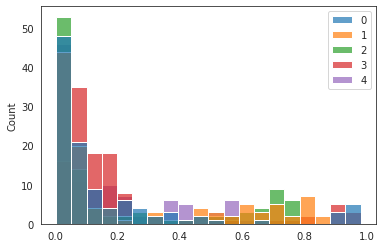

In [240]:
sns.histplot(model.cluster_centers_.T, alpha=0.7);

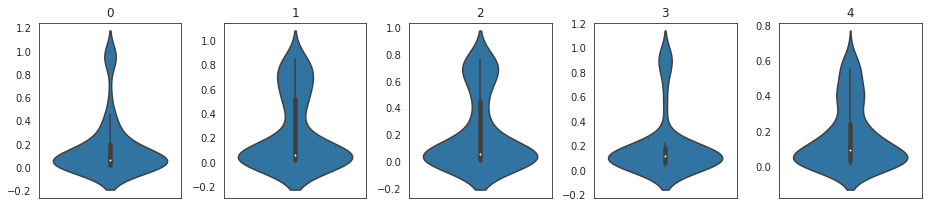

In [241]:
fig, axes = create_figure(1, num_comm, (13, 3))

for i in range(num_comm):
    sns.violinplot(y=model.cluster_centers_[i], ax=axes[i])
    axes[i].set_title(i)
plt.show()

In [242]:
memship_vec = {
    i + 1: {
        region: model.cluster_centers_[i, n]
        for n, region in net.n2l.items()
    } for i in range(num_comm)
}
memship_vol = vec2vol(memship_vec, mice)

In [243]:
qs = np.linspace(0.1, 0.99, 100)
sym_scores = []
for q in tqdm(qs):
    comms_quant = {
        i: v > np.quantile(v[v > 0], q)
        for i, v in memship_vol.items()
    }
    _scores = []
    for m in comms_quant.values():
        s = symmetry_score(
            m=m,
            mask_l=mice.parcel.results['mask_l'],
            mask_r=mice.parcel.results['mask_r'],
        )
        _scores.append(s)
    sym_scores.append(np.mean(_scores))

  0%|          | 0/100 [00:00<?, ?it/s]

/home/hadi/Dropbox/git/Ca-fMRI/analysis/helper.py:181: RuntimeWarning:

invalid value encountered in long_scalars



<matplotlib.lines.Line2D object at 0x7f309ce80dc0>

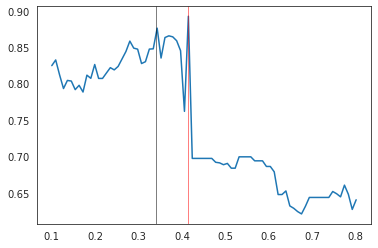

In [273]:
plt.plot(qs, sym_scores)
# plt.axvline(0.2, color='r', lw=0.5)
plt.axvline(0.34123, color='k', lw=0.5)
plt.axvline(0.4127, color='r', lw=0.5)

In [274]:
q_good = [0.34123, 0.4127]

In [275]:
q = q_good[1]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}

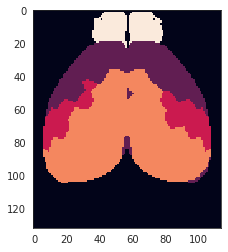

In [276]:
x3d, x2d = masks2partition(comms_quant, dims_flat)
plt.imshow(x2d);

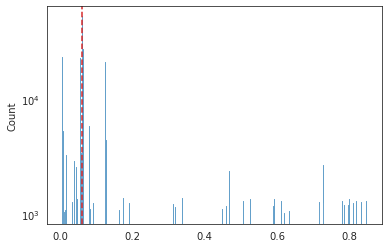

In [277]:
v = memship_vol[2].copy()

sns.histplot(v[v > 0].ravel())
plt.axvline(np.quantile(v[v > 0], q), color='C3', ls='--')
plt.yscale('log')

In [278]:
q = q_good[1]

comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comms_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comms_vec_quant.values()))

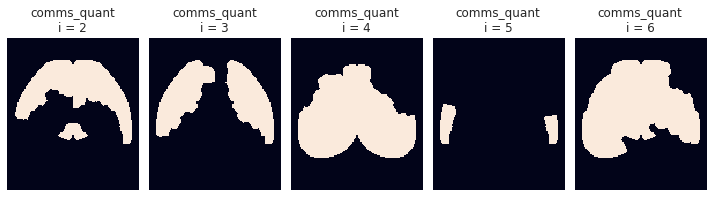

In [279]:
fig, axes = create_figure(1, num_comm, (10, 3.))

for ii in range(1, num_comm + 1):
    _, x2d = masks2partition(
        masks={ii: np.logical_and(mice.allen['isocortex_mask'], comms_quant[ii])},
        dims_flat=dims_flat,
    )
    axes[ii - 1].imshow(x2d)
    axes[ii - 1].set_title(f"comms_quant\ni = {ii+1}")
    
remove_ticks(axes)

In [280]:
centers = dc(model.cluster_centers_)
metrics = [
    'cosine',
    'correlation',
    'braycurtis',
    'jensenshannon',
]
dict_list = []
perms = {}
for run_name, run in svinet_results[expt_name].items():
    dists = {
        metric: sp_dist.cdist(
            XA=centers.astype(float),
            XB=run['pi'].astype(float),
            metric=metric,
        ) for metric in metrics
    }
    scores = {
        metric: 1 - d
        for metric, d in dists.items()
    }
    mapping = find_best_match(scores['cosine'])
    perms[run_name] = mapping

    for metric, s in scores.items():
        data_dict = {
            'OC': range(1, num_comm + 1),
            'run': [run_name] * num_comm,
            'metric': [metric] * num_comm,
            'score': np.diag(s[:, list(mapping.values())]),
        }
        dict_list.append(data_dict)
results = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

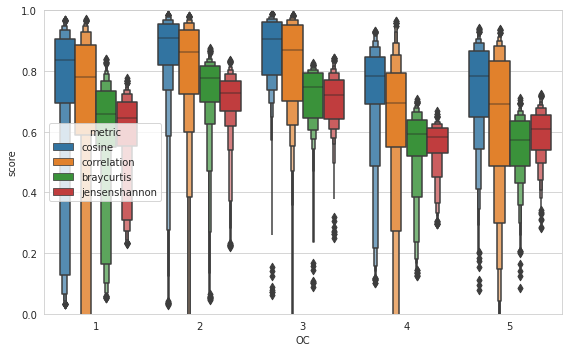

In [281]:
fig, ax = create_figure(1, 1, (8, 5), 'whitegrid')

sns.boxenplot(data=results, x='OC', y='score', hue='metric', ax=ax)
ax.set_ylim(0, 1)
plt.show()

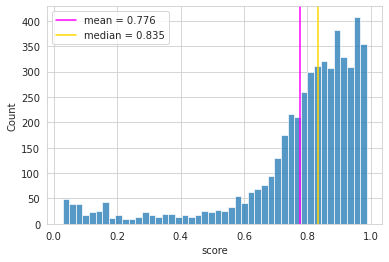

In [282]:
selected_df = results.loc[results.metric.isin(['cosine'])]
_mean = selected_df.score.mean()
_median = selected_df.score.median()

sns.histplot(data=selected_df, x='score')
plt.axvline(_mean, color='magenta', label=f"mean = {_mean:.3f}")
plt.axvline(_median, color='gold', label=f"median = {_median:.3f}")
plt.legend();

In [283]:
svinet_aligned = collections.defaultdict(dict)
for name in svinet_results:
    for run_name, run in svinet_results[name].items():
        mapping = perms[run_name]
        mapping_inv = dict(map(reversed, mapping.items()))

        community = {
            mapping_inv[idx] + 1: [net.n2l[e] for e in comm_list]
            for idx, comm_list in run['community_sv'].items()
        }
        community = dict(sorted(community.items()))
        membership = {
            net.n2l[i]: mem[list(mapping.values())]
            for i, mem in run['membership_sv'].items()
        }
        partition = {
            net.n2l[i]: mapping_inv[idx] + 1
            for i, idx in run['partition_sv'].items()
        }
        pi = run['pi'][list(mapping.values())]
        
        _partition = {i: comm_idx for i, comm_idx in enumerate(np.argmax(pi, axis=0))}
        _pi = np.concatenate([np.reshape(item, (1, -1)) for item in membership.values()]).T
        if np.sum([i - 1 != j for i, j in zip(partition.values(), _partition.values())]) > 3:
            print('warning type 1')
        if np.abs(_pi - pi).sum() > 1e-10:
            print('warning type 2')
        
        run_aligned = {
            'community': community,
            'membership': membership,
            'partition': partition,
            'pi': np.round(pi, 2),
            'num_missing': run.get('num_missing'),
            'num_overlap': run.get('num_overlap'),            
        }
        svinet_aligned[name].update({run_name: run_aligned})
svinet_aligned = dict(svinet_aligned)

In [284]:
oc_aligned = {}
for run_name, run in svinet_aligned[expt_name].items():
    comm_vec = {
        idx: np.reshape([
            1 if region in v else 0
            for region in net.l2n
        ], (1, -1))
        for idx, v in run['community'].items()
    }
    oc_aligned[run_name] = np.concatenate(list(comm_vec.values()))

In [285]:
dict_list = []
for run_name in svinet_results[expt_name]:
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'oc_vec': oc_aligned[run_name][i],
            'oc_vec_sorted': sorted(oc_aligned[run_name][i]),
        }
        dict_list.append(data_dict)

oc_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

In [286]:
oc_flat_df.shape

(548900, 5)

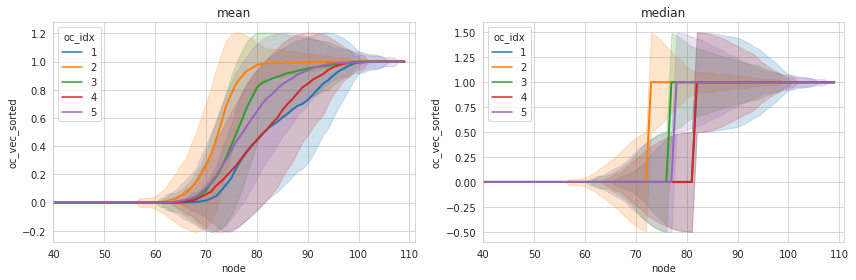

In [287]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=oc_flat_df,
        x='node',
        y='oc_vec_sorted',
        hue='oc_idx',
        lw=2,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [288]:
dict_list = []
for run_name, run in svinet_aligned[expt_name].items():
    for i in range(num_comm):
        data_dict = {
            'node': net.n2l,
            'run': [run_name] * len(net.n2l),
            'oc_idx': [i + 1] * len(net.n2l),
            'pi_vec': run['pi'][i],
            'pi_vec_sorted': sorted(run['pi'][i]),
        }
        dict_list.append(data_dict)
pi_flat_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

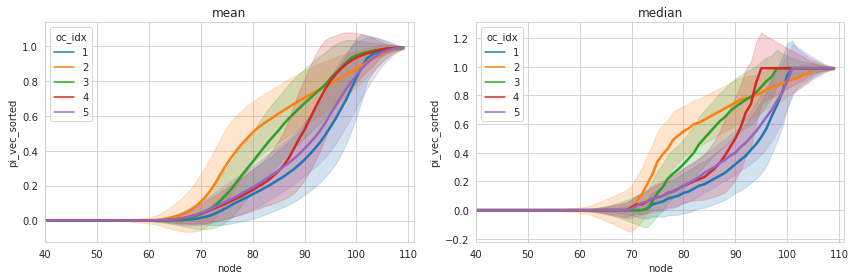

In [289]:
fig, axes = create_figure(1, 2, (12, 4), 'whitegrid')

for estimator, ax in zip([np.mean, np.median], axes):
    sns.lineplot(
        data=pi_flat_df,
        x='node',
        y='pi_vec_sorted',
        hue='oc_idx',
        lw=2.5,
        ci='sd',
        palette='tab10',
        estimator=estimator,
        ax=ax,
    )
    ax.set_title(estimator.__name__)
    ax.set_xlim(40, len(net.n2l) + 1)
plt.show()

In [290]:
q = q_good[1]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
comm_vec_quant = {
    i: np.reshape([
        np.logical_and(mice.parcel.results['roi_masks'][region], m).sum().astype(bool)
        for region in net.n2l.values()
    ], (1, -1)).astype(float)
    for i, m in comms_quant.items()
}
centers_quant = np.concatenate(list(comm_vec_quant.values()))

In [291]:
masks_aligned = {}
for run_id, (run_name, run) in enumerate(svinet_aligned[expt_name].items()):
    if run_id > 10:
        break
    masks_cortex = {
        i: np.logical_and(m, mice.allen['isocortex_mask'])
        for i, m in community2masks(run['community'], mice).items()
    }
    masks_aligned[run_name] = masks_cortex

In [292]:
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)
x2d_full_can = masks2partition(comms_quant, dims_flat)[-1]
x2d_full_can = filter_boundaries(x2d_full_can, mice.parcel.results2d['atlas'])

In [293]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [294]:
dict_list = []
for run_name, run in tqdm(svinet_aligned[expt_name].items()):
    for i in range(num_comm):
        mem = run['pi'][i]
        mem_cut = pd.cut(mem[mem > 0], bins).value_counts()       
        
        counts = mem_cut.values.tolist()
        if not sum(counts):
            print('vay dada: ', run_name, i)
            continue
        
        percent = [x/sum(counts) * 100 for x in counts]
        intervals = mem_cut.index.tolist()
        
        data_dict = {
            'run': [run_name] * len(mem_cut),
            'oc_idx': [i + 1] * len(mem_cut),
            'count': counts,
            'percent': percent,
            'interval': intervals,
        }
        dict_list.append(data_dict)
pi_cut_df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/998 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [300]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
pal = sns.color_palette(cmap, n_colors=len(bins))
pal

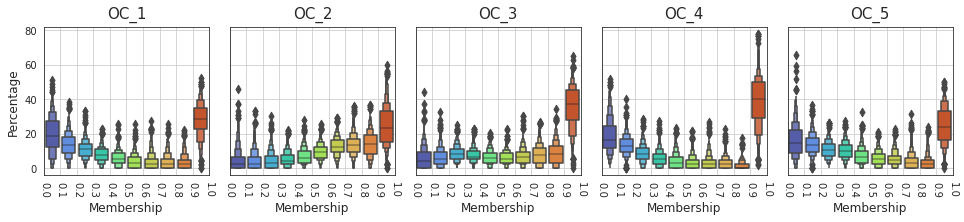

In [307]:
nrows = 1
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 3.2), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.boxenplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=pal,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=10)
    axes[i, j].tick_params('x', rotation=-90)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=15, y=1.02)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=12)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

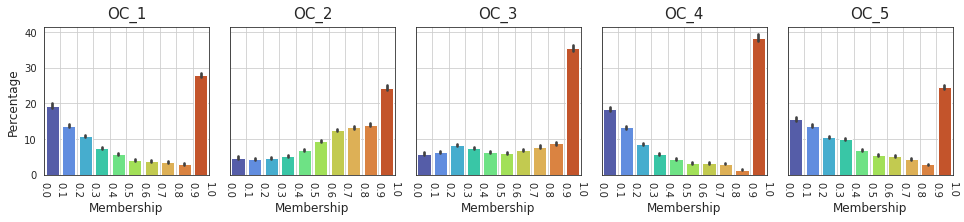

In [308]:
nrows = 1
ncols = int(np.ceil(num_comm / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 3.2), 'white', 'all', 'all', reshape=True)

for ctr, oc_idx in enumerate(sorted(pi_cut_df.oc_idx.unique())):
    i, j = ctr//ncols, ctr%ncols
    selected_df = pi_cut_df.loc[
        pi_cut_df.oc_idx == oc_idx
    ]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=pal,
        ax=axes[i, j],
    )

    # ticks
    axes[i, j].set(
        xticks=xticks,
        xticklabels=xticklabels,
    )
    axes[i, j].tick_params('both', labelsize=10)
    axes[i, j].tick_params('x', rotation=-90)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title(f"OC_{oc_idx}", fontsize=15, y=1.02)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=12)
    else:
        axes[i, j].set_ylabel('')

trim_axs(axes, num_comm)
plt.show()

In [309]:
q = q_good[1]
comms_quant = {
    i: v > np.quantile(v[v > 0], q)
    for i, v in memship_vol.items()
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in comms_quant.items()
}
contour = filter_boundaries(
    x_list=mice.parcel.results2d['contour'],
    mask=mice.parcel.results2d['atlas'],
)

In [310]:
colors = {i+1: f"C{i}" for i in range(num_comm)}

colors_fancy = [
    '#3d6af5', '#f5af3d', '#3df599',
    '#f5443d', '#a03df5', '#edf53d',
    '#f53d91', '#3df5f1', '#f5603d',
    '#92f53d', '#3d46f5', '#f53def',
    '#f5a37a', 
]
colors_fancy = {i + 1: c for i, c in enumerate(colors_fancy)}

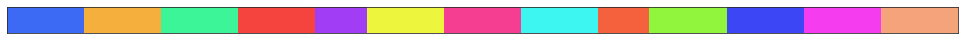

In [311]:
oc_cmap = make_cmap(
    list(colors_fancy.values()),
    n_colors=len(colors_fancy),
    name='OC',
)

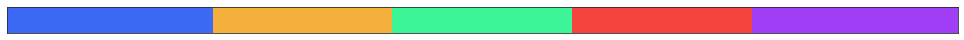

In [312]:
oc_cmap = make_cmap(
    list(colors_fancy.values())[:num_comm],
    n_colors=num_comm,
    name='OC',
)

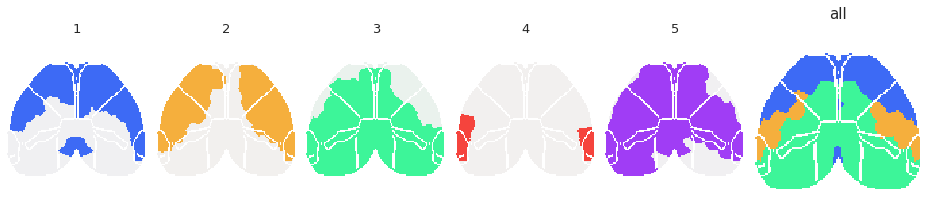

In [313]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [314]:
import ants
template = ants.from_numpy(mice.allen['template'].astype(float))

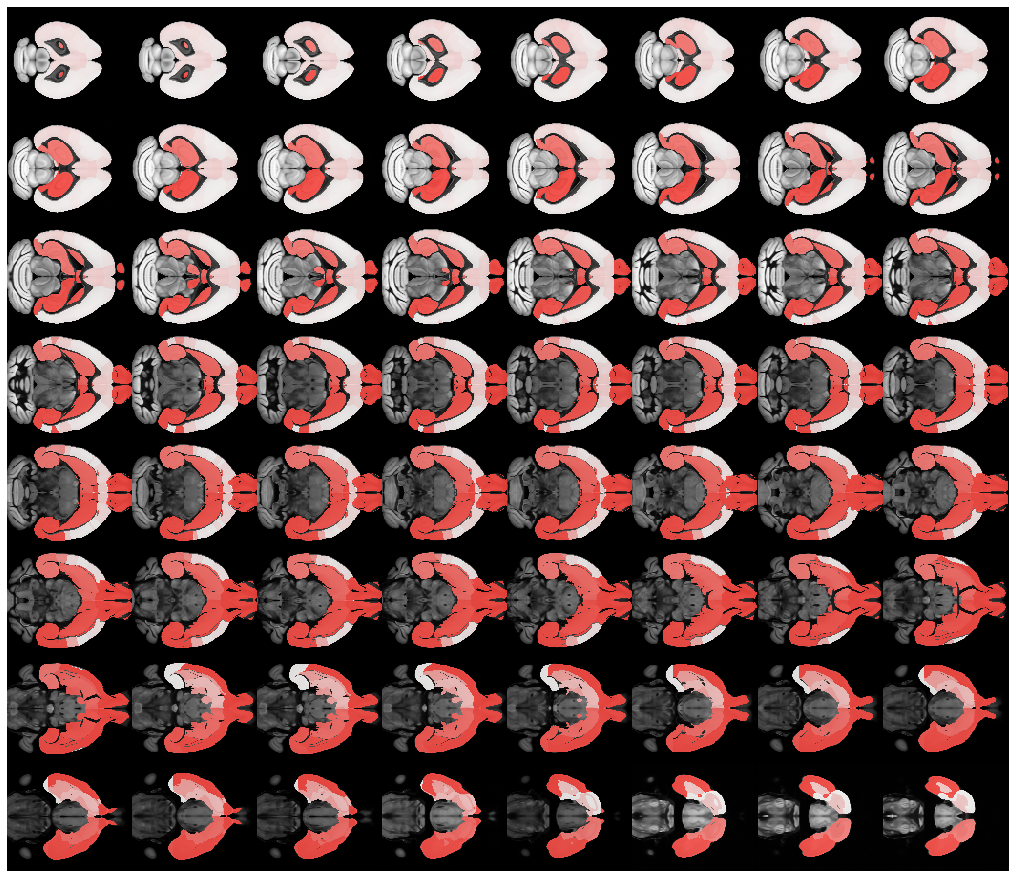

In [315]:
i = 4
img = ants.from_numpy(memship_vol[i])
cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)

template.plot(
    cmap='Greys_r',
    overlay=img,
    overlay_cmap=cmap,
    axis=1,
    nslices=64,
)

In [316]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_overlap",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p15_overlap_k5.html

### Crisp

In [317]:
partition = np.argmax(model.cluster_centers_, axis=0)
partition = {
    net.n2l[i]: idx + 1
    for i, idx in enumerate(partition)
}
community = {
    ii: list(itertools.compress(
        data=net.l2n,
        selectors=[ii == jj for jj in partition.values()],
    ))
    for ii in set(partition.values())
}
masks_cortex = {
    i: np.logical_and(m, mice.allen['isocortex_mask'])
    for i, m in community2masks(community, mice).items()
}

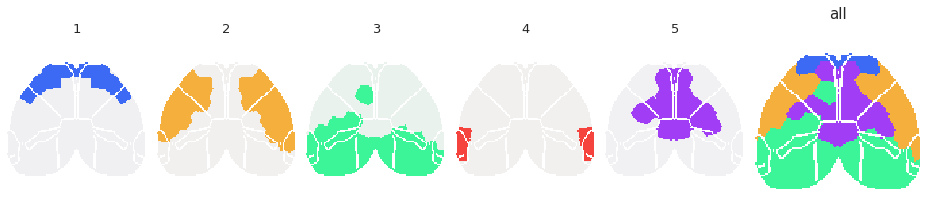

In [318]:
fig, axes = create_figure(1, num_comm + 1, (13, 3), gridspec_kw={'width_ratios': [1] * num_comm + [1.2]})

x2d_full = masks2partition(masks_cortex, dims_flat)[-1]
x2d_full = filter_boundaries(x2d_full, mice.parcel.results2d['atlas'])
cond = np.logical_or(contour, x2d_full == 0)
data2plt = np.ma.masked_where(cond, x2d_full)
_c = [c for i, c in colors_fancy.items() if i in np.unique(data2plt)]
_cmap = make_cmap(
    ramp_colors=_c,
    n_colors=len(_c),
    show=False,
)
axes[-1].imshow(data2plt, cmap=_cmap)
axes[-1].set_title('all', fontsize=15)

for i, ax in zip(range(1, num_comm+1), axes):
    x2d = masks2partition({i: masks_cortex[i]}, dims_flat)[-1]
    x2d = filter_boundaries(x2d, mice.parcel.results2d['atlas'])
    data2plt = np.ma.masked_where(cond, x2d)
    cmap = sns.light_palette(colors_fancy[i], n_colors=2, as_cmap=True)
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(i, fontsize=13)

remove_ticks(axes)
plt.show()

In [319]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

_ = parcel2html(
    masks=masks_cortex,
    save_dir=extras_dir,
    save_name=f"SVINET_n{mice.cfg.n_cortex_regions}-p{perc}_disjoint",
    cmap=oc_cmap,
    base_name=None,
    alpha=1.0,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/SVINET_n100-p15_disjoint_k5.html